# Setup

Install tensorflow and tensorflow quantum if necessary.

In [4]:
%load_ext autoreload

In [6]:
!pip install tensorflow==2.7.0


[notice] A new release of pip is available: 23.0.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip


In [7]:
!pip install tensorflow-quantum==0.7.2


[notice] A new release of pip is available: 23.0.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip


In [8]:
# Update package resources to account for version changes.
import importlib, pkg_resources
importlib.reload(pkg_resources)

<module 'pkg_resources' from '/home/hpn/anaconda3/lib/python3.9/site-packages/pkg_resources/__init__.py'>

Import tensorflow and the module dependencies:

In [9]:
import tensorflow as tf
import tensorflow_quantum as tfq

import cirq
import sympy
import numpy as np

from tqdm import trange
import pickle

# Results

In [10]:
%autoreload 2

We create three different stilted dataset from fashion MNIST through three CQCA-based quantum models and attempt to learn each with the other.
In the following we illustrate the models.

In [ ]:
from model.pqca import PQCACirc

# Global params
NUM_QUBITS = 6
QUBITS = cirq.GridQubit.rect(1, NUM_QUBITS)
OBSERVABLES = [cirq.Z(QUBITS[0])]
NUM_LAYERS_ENC = 1

# Model C params 
NUM_LAYERS_VAR_C = 4
SINGLE_PARAM_C = False
CQCA_C = [["CZ1", "H"]]

variational_c = PQCACirc(QUBITS, NUM_LAYERS_VAR_C, CQCA_C, OBSERVABLES, SINGLE_PARAM_C)
print(variational_c.circuit)
print()
print()

# Model CF params
NUM_LAYERS_VAR_CF = 4
SINGLE_PARAM_CF = False
CQCA_CF = [["H", "S", "H", "CZ1", "H"]] #[["CZ1", "S", "H", "S", "H"]]

variational_cf = PQCACirc(QUBITS, NUM_LAYERS_VAR_CF, CQCA_CF, OBSERVABLES, SINGLE_PARAM_CF)
print(variational_cf.circuit)
print()

# Model CP params
NUM_LAYERS_VAR_CP = 4
SINGLE_PARAM_CP = False
CQCA_CP = [["CZ1", "H"], ["H"]]

variational_c = PQCACirc(QUBITS, NUM_LAYERS_VAR_CP, CQCA_CP, OBSERVABLES, SINGLE_PARAM_CP)
print(variational_c.circuit)
print()
print()


(0, 0): ───Rz(theta0)───@───────────────────@───H───Rz(theta6)────@───────────────────@───H───Rz(theta12)───@───────────────────@───H───Rz(theta18)───@───────────────────@───H───
                        │                   │                     │                   │                     │                   │                     │                   │
(0, 1): ───Rz(theta1)───@───@───────────────┼───H───Rz(theta7)────@───@───────────────┼───H───Rz(theta13)───@───@───────────────┼───H───Rz(theta19)───@───@───────────────┼───H───
                            │               │                         │               │                         │               │                         │               │
(0, 2): ───Rz(theta2)───────@───@───────────┼───H───Rz(theta8)────────@───@───────────┼───H───Rz(theta14)───────@───@───────────┼───H───Rz(theta20)───────@───@───────────┼───H───
                                │           │                             │           │                             │  

## Training

We define a function that creates a dataset given a target model and trains a learning model on that dataset. Then it saves both models in approrpirate files.

In [ ]:
def train_save_model(model_train, model_data, num_steps, num_train, num_test, norm, path, path_data):
    """
    Generates a stilted dataset from a given model, then trains a given other
    model on the dataset. Results and data are saved.
    
    Args:
        model_train (PQCAModel): The training model.
        model_data (DataFMNISTModel): The data generating model.
        num_steps (int): The number of training steps.
        num_train (int): The size of the training data.
        num_test (int): The size of the test and validation data.
        norm (bool): Whether or not the output should be normalized by the std.
        path (str): Where to save the training model data.
        path_data (str): Where to save the data generating model data.
    """
    # generate data
    x_train, y_train, x_test, y_test, x_test2, y_test2, x_train_save, _ , _ = model_data.create_fMNIST(num_train, num_test, norm)
    
    # training
    tr = trange(num_steps)
    for step in tr:
        # calculate loss and validation loss in a training step
        # data is automatically appended
        l, val = model_train.step(x_train, y_train, x_test, y_test)
        # calculate test loss (not from training)
        test = tf.keras.losses.MeanSquaredError()(model_train.model(x_test2), y_test2).numpy()

        # append test data
        model_train.test_history += [test]

        # Print metrics every 10 epochs
        if(step % 10 == 0):
            tr.set_postfix({ "training loss": round(l,8), "validation loss": round(val,8), "test loss": round(test,8)})

        # if val<10**(-5):
        #     break

    model_train.pickle_model(path)
    model_data.pickle_model(path_data)

Load appropriate models and specify parameters.

In [ ]:
from model.pqca import PQCAModel
from examples.data_model import DataFMNISTModel

# Data params
TRAIN= False
NUM_TRAIN = 500
NUM_TEST = 100
NORM = True

# Training params
NUM_STEPS = 500
NUM_MODELS = 20
START_MODEL = 10
LR_VAR = 0.01
LR_OUT = 0.1

### Cluster CQCA as target

**Target:** Cluster CQCA

**Learning Model:** Cluster CQCA

In [ ]:
# NUM_MODELS = 10
# START_MODEL = 0

# target: cluster CQCA
# learning model: cluster CQCA
for m in range(START_MODEL, NUM_MODELS):
    # Define model for data generation - cluster CQCA
    model_data = DataFMNISTModel(QUBITS, 
                                 NUM_LAYERS_ENC, 
                                 NUM_LAYERS_VAR_C, 
                                 CQCA_C, 
                                 OBSERVABLES, 
                                 False, 
                                 SINGLE_PARAM_C)
    # Define model - cluster CQCA
    model_train = PQCAModel(QUBITS, 
                            NUM_LAYERS_ENC, 
                            NUM_LAYERS_VAR_C, 
                            CQCA_C, 
                            OBSERVABLES, 
                            True, 
                            SINGLE_PARAM_C,
                            lr_var=LR_VAR,
                            lr_out=LR_OUT)

    
    path_data = "./results/data_c_learns_c_"+str(m)+".pckl"
    path = "./results/results_c_learns_c_"+str(m)+".pckl"

    # run training an save
    train_save_model(model_train, 
                     model_data, 
                     NUM_STEPS, 
                     NUM_TRAIN, 
                     NUM_TEST, 
                     NORM, 
                     path, 
                     path_data)

100%|██████████| 500/500 [13:25<00:00,  1.61s/it, training loss=1e-8, validation loss=1e-8, test loss=1e-8]            


**Target:** Cluster CQCA

**Learning Model:** Fractal cluster CQCA

In [ ]:
# NUM_MODELS = 10
# START_MODEL = 0

# target: cluster CQCA
# learning model: fractal cluster CQCA
for m in range(START_MODEL, NUM_MODELS):
    # Define model for data generation - cluster CQCA
    model_data = DataFMNISTModel(QUBITS, 
                                 NUM_LAYERS_ENC, 
                                 NUM_LAYERS_VAR_C, 
                                 CQCA_C, 
                                 OBSERVABLES, 
                                 False, 
                                 SINGLE_PARAM_C)
    # Define model - fractal cluster CQCA
    model_train = PQCAModel(QUBITS, 
                            NUM_LAYERS_ENC, 
                            NUM_LAYERS_VAR_CF, 
                            CQCA_CF, 
                            OBSERVABLES, 
                            True, 
                            SINGLE_PARAM_CF)
    
    path_data = "./results/data_cf_learns_c_"+str(m)+".pckl"
    path = "./results/results_cf_learns_c_"+str(m)+".pckl"

    # run training an save
    train_save_model(model_train, 
                     model_data, 
                     NUM_STEPS, 
                     NUM_TRAIN, 
                     NUM_TEST, 
                     NORM, 
                     path, 
                     path_data)

100%|██████████| 500/500 [09:33<00:00,  1.15s/it, training loss=0.739, validation loss=0.955, test loss=1.08]


**Target:** Cluster CQCA

**Learning Model:** Periodic cluster CQCA

In [ ]:
# NUM_MODELS = 10
# START_MODEL = 0

# target: cluster CQCA
# learning model: periodic cluster CQCA
for m in range(START_MODEL, NUM_MODELS):
    # Define model for data generation - cluster CQCA
    model_data = DataFMNISTModel(QUBITS, 
                                 NUM_LAYERS_ENC, 
                                 NUM_LAYERS_VAR_C, 
                                 CQCA_C, 
                                 OBSERVABLES, 
                                 False, 
                                 SINGLE_PARAM_C)
    # Define model - fractal cluster CQCA
    model_train = PQCAModel(QUBITS, 
                            NUM_LAYERS_ENC, 
                            NUM_LAYERS_VAR_CP, 
                            CQCA_CP, 
                            OBSERVABLES, 
                            True, 
                            SINGLE_PARAM_CP)
    
    path_data = "./results/data_cp_learns_c_"+str(m)+".pckl"
    path = "./results/results_cp_learns_c_"+str(m)+".pckl"

    # run training an save
    train_save_model(model_train, 
                     model_data, 
                     NUM_STEPS, 
                     NUM_TRAIN, 
                     NUM_TEST, 
                     NORM, 
                     path, 
                     path_data)

  0%|          | 0/500 [00:00<?, ?it/s]

100%|██████████| 500/500 [04:55<00:00,  1.69it/s, training loss=0.923, validation loss=1.01, test loss=1.01]


### Fractal Cluster CQCA as target

**Target:** Fractal cluster CQCA

**Learning Model:** Cluster CQCA

In [ ]:
# NUM_MODELS = 10
# START_MODEL = 0

# target: fractal cluster CQCA
# learning model: cluster CQCA
for m in range(START_MODEL, NUM_MODELS):
    # Define model for data generation - fractal cluster CQCA
    model_data = DataFMNISTModel(QUBITS, 
                                 NUM_LAYERS_ENC, 
                                 NUM_LAYERS_VAR_CF, 
                                 CQCA_CF, 
                                 OBSERVABLES, 
                                 False, 
                                 SINGLE_PARAM_CF)
    # Define model - cluster CQCA
    model_train = PQCAModel(QUBITS, 
                            NUM_LAYERS_ENC, 
                            NUM_LAYERS_VAR_C, 
                            CQCA_C, 
                            OBSERVABLES, 
                            True, 
                            SINGLE_PARAM_C)
    
    path_data = "./results/data_c_learns_cf_"+str(m)+".pckl"
    path = "./results/results_c_learns_cf_"+str(m)+".pckl"

    # run training an save
    train_save_model(model_train, 
                     model_data, 
                     NUM_STEPS, 
                     NUM_TRAIN, 
                     NUM_TEST, 
                     NORM, 
                     path, 
                     path_data)

100%|██████████| 500/500 [05:40<00:00,  1.47it/s, training loss=0.821, validation loss=0.646, test loss=0.884]


**Target:** Fractal cluster CQCA

**Learning Model:** Fractal cluster CQCA

In [ ]:
# NUM_MODELS = 10
# START_MODEL = 0

# target: fractal cluster CQCA
# learning model: fractal cluster CQCA
for m in range(START_MODEL, NUM_MODELS):
    # Define model for data generation - fractal cluster CQCA
    model_data = DataFMNISTModel(QUBITS, 
                                 NUM_LAYERS_ENC, 
                                 NUM_LAYERS_VAR_CF, 
                                 CQCA_CF, 
                                 OBSERVABLES, 
                                 False, 
                                 SINGLE_PARAM_CF)
    # Define model - fractal cluster CQCA
    model_train = PQCAModel(QUBITS, 
                            NUM_LAYERS_ENC, 
                            NUM_LAYERS_VAR_CF, 
                            CQCA_CF, 
                            OBSERVABLES, 
                            True, 
                            SINGLE_PARAM_CF)
    
    path_data = "./results/data_cf_learns_cf_"+str(m)+".pckl"
    path = "./results/results_cf_learns_cf_"+str(m)+".pckl"

    # run training an save
    train_save_model(model_train, 
                     model_data, 
                     NUM_STEPS, 
                     NUM_TRAIN, 
                     NUM_TEST, 
                     NORM, 
                     path, 
                     path_data)

  0%|          | 0/500 [00:00<?, ?it/s]

100%|██████████| 500/500 [09:31<00:00,  1.14s/it, training loss=1e-8, validation loss=1e-8, test loss=1e-8]            


**Target:** Fractal cluster CQCA

**Learning Model:** Periodic cluster CQCA

In [ ]:
# NUM_MODELS = 10
# START_MODEL = 0

# target: fractal cluster CQCA
# learning model: periodic cluster CQCA
for m in range(START_MODEL, NUM_MODELS):
    # Define model for data generation - fractal cluster CQCA
    model_data = DataFMNISTModel(QUBITS, 
                                 NUM_LAYERS_ENC, 
                                 NUM_LAYERS_VAR_CF, 
                                 CQCA_CF, 
                                 OBSERVABLES, 
                                 False, 
                                 SINGLE_PARAM_CF)
    # Define model - periodic cluster CQCA
    model_train = PQCAModel(QUBITS, 
                            NUM_LAYERS_ENC, 
                            NUM_LAYERS_VAR_CP, 
                            CQCA_CP, 
                            OBSERVABLES, 
                            True, 
                            SINGLE_PARAM_CP)
    
    path_data = "./results/data_cp_learns_cf_"+str(m)+".pckl"
    path = "./results/results_cp_learns_cf_"+str(m)+".pckl"

    # run training an save
    train_save_model(model_train, 
                     model_data, 
                     NUM_STEPS, 
                     NUM_TRAIN, 
                     NUM_TEST, 
                     NORM, 
                     path, 
                     path_data)

100%|██████████| 500/500 [04:55<00:00,  1.69it/s, training loss=0.951, validation loss=0.903, test loss=1.04]


### Periodic cluster CQCA as a target

**Target:** Periodic cluster CQCA

**Learning Model:** Cluster CQCA

In [ ]:
# NUM_MODELS = 10
# START_MODEL = 0

# target: periodic cluster CQCA
# learning model: cluster CQCA
for m in range(START_MODEL, NUM_MODELS):
    # Define model for data generation - periodic cluster CQCA
    model_data = DataFMNISTModel(QUBITS, 
                                 NUM_LAYERS_ENC, 
                                 NUM_LAYERS_VAR_CP, 
                                 CQCA_CP, 
                                 OBSERVABLES, 
                                 False, 
                                 SINGLE_PARAM_CP)
    # Define model - cluster CQCA
    model_train = PQCAModel(QUBITS, 
                            NUM_LAYERS_ENC, 
                            NUM_LAYERS_VAR_C, 
                            CQCA_C, 
                            OBSERVABLES, 
                            True, 
                            SINGLE_PARAM_C)
    
    path_data = "./results/data_c_learns_cp_"+str(m)+".pckl"
    path = "./results/results_c_learns_cp_"+str(m)+".pckl"

    # run training an save
    train_save_model(model_train, 
                     model_data, 
                     NUM_STEPS, 
                     NUM_TRAIN, 
                     NUM_TEST, 
                     NORM, 
                     path, 
                     path_data)

100%|██████████| 500/500 [05:40<00:00,  1.47it/s, training loss=0.912, validation loss=0.943, test loss=1.57]


**Target:** Periodic cluster CQCA

**Learning Model:** Fractal cluster CQCA

In [ ]:
# NUM_MODELS = 10
# START_MODEL = 0

# target: periodic cluster CQCA
# learning model: fractal cluster CQCA
for m in range(START_MODEL, NUM_MODELS):
    # Define model for data generation - periodic cluster CQCA
    model_data = DataFMNISTModel(QUBITS, 
                                 NUM_LAYERS_ENC, 
                                 NUM_LAYERS_VAR_CP, 
                                 CQCA_CP, 
                                 OBSERVABLES, 
                                 False, 
                                 SINGLE_PARAM_CP)
    # Define model - fractal cluster CQCA
    model_train = PQCAModel(QUBITS, 
                            NUM_LAYERS_ENC, 
                            NUM_LAYERS_VAR_CF, 
                            CQCA_CF, 
                            OBSERVABLES, 
                            True, 
                            SINGLE_PARAM_CF)
    
    path_data = "./results/data_cf_learns_cp_"+str(m)+".pckl"
    path = "./results/results_cf_learns_cp_"+str(m)+".pckl"

    # run training an save
    train_save_model(model_train, 
                     model_data, 
                     NUM_STEPS, 
                     NUM_TRAIN, 
                     NUM_TEST, 
                     NORM, 
                     path, 
                     path_data)

  0%|          | 0/500 [00:00<?, ?it/s]

  1%|          | 3/500 [00:07<20:58,  2.53s/it, training loss=1.05, validation loss=1, test loss=1.36]


KeyboardInterrupt: 

**Target:** Periodic cluster CQCA

**Learning Model:** Periodic cluster CQCA

In [ ]:
# NUM_MODELS = 10
START_MODEL = 16

# target: periodic cluster CQCA
# learning model: periodic cluster CQCA
for m in range(START_MODEL, NUM_MODELS):
    # Define model for data generation - periodic cluster CQCA
    model_data = DataFMNISTModel(QUBITS, 
                                 NUM_LAYERS_ENC, 
                                 NUM_LAYERS_VAR_CP, 
                                 CQCA_CP, 
                                 OBSERVABLES, 
                                 False, 
                                 SINGLE_PARAM_CP)
    # Define model - periodic cluster CQCA
    model_train = PQCAModel(QUBITS, 
                            NUM_LAYERS_ENC, 
                            NUM_LAYERS_VAR_CP, 
                            CQCA_CP, 
                            OBSERVABLES, 
                            True, 
                            SINGLE_PARAM_CP)
    
    path_data = "./results/data_cp_learns_cp_"+str(m)+".pckl"
    path = "./results/results_cp_learns_cp_"+str(m)+".pckl"

    # run training an save
    train_save_model(model_train, 
                     model_data, 
                     NUM_STEPS, 
                     NUM_TRAIN, 
                     NUM_TEST, 
                     NORM, 
                     path, 
                     path_data)

100%|██████████| 500/500 [10:31<00:00,  1.26s/it, training loss=0.00194, validation loss=0.00216, test loss=0.00232]


## Analysis

Load analysis dependencies.

In [54]:
from matplotlib import pyplot as plt
import matplotlib as mpl
mpl.rc('font',family='Times New Roman')

Define function that shows all the important results for the different learning models.

In [53]:
def plot_results(paths, name_models, num_models, name_plot,
                 colors=[['#000000', '#000000', '#DADADA'],
                         ['#785ef0', '#785ef0', '#648fff'],
                         ['#dc267f', '#dc267f', '#FE6100']
                #  colors=[['#CC4F1B', '#CC4F1B', '#FF9848'],
                #          ['#1B2ACC', '#1B2ACC', '#089FFF'],
                #          ['#15695F', '#1D9485', '#89C7BC']
                        ]):
    """
    Function that shows all the important results.
    
    Args:
        paths (list of str): The paths where models have been saved.
        name_models (list of str): The associated names of models.
        num_models (int): The number of models we average over.
        name_plot (str): The plot label.
        colors (list of list of str): The plot colors in hex for mean and std. 
                                Default: [['#000000', '#000000', '#DADADA'],
                                          ['#785ef0', '#785ef0', '#648fff'],
                                          ['#dc267f', '#dc267f', '#FE6100']
                                         ]
    """

    plt.clf()

    mean_converged = []
    std_converged = []
    best_converged = []
    worst_converged = []

    for index, path_name in enumerate(paths):
        results = []
        results_converged = []
        for m in range(num_models):
            # c learns c
            path = "./results/"+path_name+str(m)+".pckl"
            with open(path, "rb") as input_file:
                model = pickle.load(input_file)
            # collect all test results from model
            results += [model[0].test_history]

            # collect last test results from model
            results_converged += [model[0].test_history[-1]]

        # collect best and worst results
        best_converged += [min(results_converged)]
        worst_converged += [max(results_converged)]

        # calculate mean
        mean = np.mean(results, axis=0)
        # x-axis
        x = np.array(range(len(mean)))
        # calculate standard deviation.
        std = np.std(results, axis=0)

        # collect last mean value
        mean_converged += [mean[-1]]
        std_converged += [std[-1]]

        # draw plot
        plt.plot(x,mean, color=colors[index][0])
        plt.fill_between(x, mean+std, mean-std, 
                        alpha=0.3, 
                        edgecolor=colors[index][1], 
                        facecolor=colors[index][2])

    # assign plot labels
    plt.legend((name_models[0], name_models[1], name_models[2]),
            loc='upper right', shadow=True)

    plt.grid(False)
    plt.ylabel('Mean squared error')
    plt.xlabel('Learning step')
    plt.title(name_plot)

    # Print plot.
    plt.show()

    # Print the best and worst results.
    print(
    "Converged losses:\n\n \
    {}: {} +/- {};\n\t\t Best: {}; Worst: {}\n \
    {}: {} +/- {};\n\t\t Best: {}; Worst: {}\n \
    {}: {} +/- {};\n\t\t Best: {}; Worst: {}\n".format(
            name_models[0],mean_converged[0],std_converged[0],best_converged[0],worst_converged[0],
            name_models[1],mean_converged[1],std_converged[1],best_converged[1],worst_converged[1],
            name_models[2],mean_converged[2],std_converged[2],best_converged[2],worst_converged[2]
            )
    )

## Cluster CQCA as target

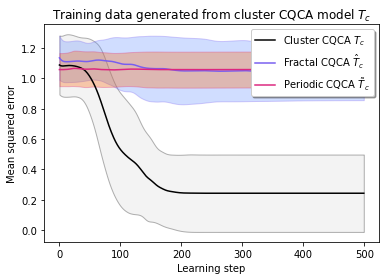

Converged losses:

     Cluster CQCA $T_c$: 0.24295620620250702 +/- 0.25496694445610046;
		 Best: 9.458732463940578e-09; Worst: 0.631986677646637
     Fractal CQCA $\hat{T}_c$: 1.0540151596069336 +/- 0.19750751554965973;
		 Best: 0.7780792713165283; Worst: 1.3331266641616821
     Periodic CQCA $\~T_c$: 1.058937430381775 +/- 0.11863476783037186;
		 Best: 0.8233383297920227; Worst: 1.3011348247528076



In [56]:
NAME_PLOT = 'Training data generated from cluster CQCA model $T_c$'
NAME_MODELS = ['Cluster CQCA $T_c$', 'Fractal CQCA $\hat{T}_c$', 'Periodic CQCA $\~T_c$']
NUM_MODELS = 10
PATHS = ["results_c_learns_c_", 
         "results_cf_learns_c_",
         "results_cp_learns_c_"]


plot_results(PATHS, NAME_MODELS, NUM_MODELS, NAME_PLOT)

## Fractal cluster CQCA as target

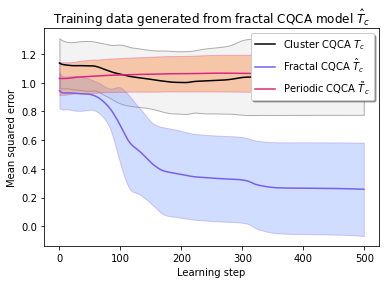

Converged losses:

     Cluster CQCA $T_c$: 1.0392611026763916 +/- 0.26291340589523315;
		 Best: 0.6713038086891174; Worst: 1.5049421787261963
     Fractal CQCA $\hat{T}_c$: 0.2579604983329773 +/- 0.3250528573989868;
		 Best: 1.184575371127039e-08; Worst: 0.9127745032310486
     Periodic CQCA $\~T_c$: 1.0595953464508057 +/- 0.1412300169467926;
		 Best: 0.767953097820282; Worst: 1.2271572351455688



In [60]:
NAME_PLOT = 'Training data generated from fractal CQCA model $\hat{T}_c$'
NAME_MODELS = ['Cluster CQCA $T_c$', 'Fractal CQCA $\hat{T}_c$', 'Periodic CQCA $\~T_c$']
NUM_MODELS = 10
PATHS = ["results_c_learns_cf_", 
         "results_cf_learns_cf_",
         "results_cp_learns_cf_"]


plot_results(PATHS, NAME_MODELS, NUM_MODELS, NAME_PLOT)

## Periodic cluster CQCA as target

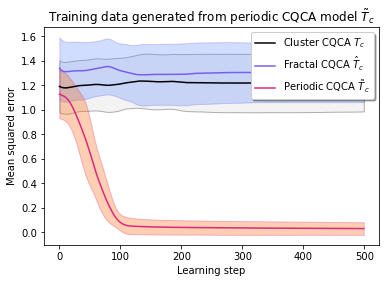

Converged losses:

     Cluster CQCA $T_c$: 1.2186912298202515 +/- 0.2308260202407837;
		 Best: 0.8159035444259644; Worst: 1.6429414749145508
     Fractal CQCA $\hat{T}_c$: 1.3053001165390015 +/- 0.24119149148464203;
		 Best: 0.9928779006004333; Worst: 1.6700952053070068
     Periodic CQCA $\~T_c$: 0.03156687691807747 +/- 0.05136173591017723;
		 Best: 1.3025876377525947e-08; Worst: 0.15909643471240997



In [62]:
NAME_PLOT = 'Training data generated from periodic CQCA model $\~T_c$'
NAME_MODELS = ['Cluster CQCA $T_c$', 'Fractal CQCA $\hat{T}_c$', 'Periodic CQCA $\~T_c$']
NUM_MODELS = 10
PATHS = ["results_c_learns_cp_", 
         "results_cf_learns_cp_",
         "results_cp_learns_cp_"]


plot_results(PATHS, NAME_MODELS, NUM_MODELS, NAME_PLOT)